# Prelim

Notebook for 10X PBMC ATAC dataset: https://support.10xgenomics.com/single-cell-atac/datasets/1.2.0/atac_pbmc_10k_nextgem

<b>ArchR installation </b>

Install from [https://github.com/settylab/ArchR](https://github.com/settylab/ArchR)

```
library(devtools)
devtools::install_github("GreenleafLab/ArchR", ref="master", repos = BiocManager::repositories())
```

Update your ArchR with the customized version
```
R CMD INSTALL -l <PATH to R personal library> <path to Git clone >
```

Review the notebook `PBMC-RNA-standalone.ipynb` for setup instructions.
Install MACS2 for peak celling 
```
conda install -c bioconda macs2 
```



## Load data

Download the following files:
1. [ATAC fragments file](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scatac/atac_pbmc_10k_nextgem_fragments.tsv.gz)
2. [Index for the fragments file](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scatac/atac_pbmc_10k_nextgem_fragments.tsv.gz.tbi)
3. [Per barcode metrics](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scatac/atac_pbmc_10k_nextgem_singlecell.csv)

Use the above files to run ArchR using the ArchR preprocessing script: https://github.com/settylab/single-cell-primers/blob/main/scripts/PBMC-ATAC-standalone-ArchR-preprocessing.R


The outputs from ArchR are available to download from: 
`s3://fh-pi-setty-m-eco-public/single-cell-primers/scatac/ArchR/`

Copy the results over to the `data/` directory using 
`aws s3 sync s3://fh-pi-setty-m-eco-public/single-cell-primers/scatac/ArchR/ data/pbmc_10x_atac/export/`

In [2]:
# Uncomment following line to download
# !aws s3 sync s3://fh-pi-setty-m-eco-public/single-cell-primers/scatac/ArchR/ data/pbmc_10x_atac/export/

# Imports

In [1]:
import os
import pandas as pd
import numpy as np

import scanpy as sc
import pyranges as pr
import warnings

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import palantir 
import phenograph
import harmony

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
%matplotlib inline
sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [4]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [5]:
def pyranges_from_strings(pos_list):
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(1)
    
    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    
    return gr

In [40]:
from joblib import Parallel, delayed
from scipy.sparse import hstack, csr_matrix, issparse
import gc

def _dot_func(x, y):
    return x.dot(y)

def imputation_weights(dm_res, ad, n_steps=3):
    T_steps = dm_res['T'] ** n_steps
    T_steps = T_steps.astype(np.float32)
        
    ad.obsp['ImputeWeights'] = T_steps

def impute_data_with_weights(ad, data):
    res = _dot_func(ad.obsp['ImputeWeights'], data)
    return pd.DataFrame(res, index=ad.obs_names, columns=data.columns)
    


# Load data

## ATAC

In [16]:
data_dir = os.path.expanduser('data/pbmc_10x_atac/export/')

Load all the exported results from ArchR

### Peaks data

In [7]:
# Peaks data
from scipy.io import mmread
counts = mmread(data_dir + 'peak_counts/counts.mtx')

In [8]:
# Cell and peak information
cells = pd.read_csv(data_dir + 'peak_counts/cells.csv', index_col=0).iloc[:, 0]
peaks = pd.read_csv(data_dir + 'peak_counts/peaks.csv', index_col=0)
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)
peaks.head()

,seqnames,start,end,width,strand,score,replicateScoreQuantile,groupScoreQuantile,Reproducibility,GroupReplicate,nearestGene,distToGeneStart,peakType,distToTSS,nearestTSS,GC,idx,N
chr1:752475-752975,chr1,752475,752975,501,*,107.26800,0.957,0.887,2,C14._.Rep1,LINC00115,8861,Distal,10176,uc001aau.3,0.4810,1,0
chr1:762714-763214,chr1,762714,763214,501,*,20.66550,0.957,0.887,2,C14._.Rep2,LINC01128,7,Promoter,6,uc021oeh.1,0.7026,2,0
chr1:773662-774162,chr1,773662,774162,501,*,2.80331,0.322,0.058,2,C7._.Rep2,LINC01128,10941,Intronic,10733,uc021oeh.1,0.4591,3,0
chr1:779830-780330,chr1,779830,780330,501,*,6.29453,0.312,0.141,2,C2._.Rep1,LINC01128,17109,Intronic,16901,uc021oeh.1,0.5150,4,0
chr1:800919-801419,chr1,800919,801419,501,*,69.04460,0.883,0.729,2,C3._.Rep1,FAM41C,2282,Distal,11012,uc021oei.1,0.4631,5,0


In [9]:
ad = sc.AnnData(counts.T)
ad.obs_names = cells
ad.var_names = peaks.index
for col in peaks.columns:
    ad.var[col] = peaks[col]

<ipython-input-9-83fb4c701231>:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad = sc.AnnData(counts.T)


In [10]:
ad.X = ad.X.tocsr()

In [11]:
ad

AnnData object with n_obs × n_vars = 9489 × 155687
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'

### SVD, UMAP and Metadata

In [12]:
# SVD
ad.obsm['X_svd'] = pd.read_csv(data_dir + 'svd.csv', index_col=0).loc[ad.obs_names, : ].values

In [13]:
# UMAP
ad.obsm['X_umap_archr'] = pd.read_csv(data_dir + 'umap.csv', index_col=0).loc[ad.obs_names, : ].values

In [14]:
# Metadata
cell_meta = pd.read_csv(data_dir + 'cell_metadata.csv', index_col=0).loc[ad.obs_names, : ]
for col in cell_meta.columns:
    ad.obs[col] = cell_meta[col].values

In [15]:
ad

AnnData object with n_obs × n_vars = 9489 × 155687
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    obsm: 'X_svd', 'X_umap_archr'

### Gene scores

In [16]:
# Gene scores
scores = mmread(data_dir + 'gene_scores/scores.mtx')

In [19]:
# Cell and peak information
cells = pd.read_csv(data_dir + 'gene_scores/cells.csv', index_col=0).iloc[:, 0]
genes = pd.read_csv(data_dir + 'gene_scores/genes.csv', index_col=0).iloc[:, 0]


In [82]:
ad.obsm['GeneScores'] = scores.T.tocsr()
ad.uns['GeneScoresColums'] = genes

In [27]:
ad

AnnData object with n_obs × n_vars = 9489 × 155687
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums'
    obsm: 'X_svd', 'X_umap_archr', 'GeneScores'

### chromVAR

In [32]:
chromvar = pd.read_csv(data_dir + 'chromvar_motif_scores.csv', index_col=0)
chromvar

,pbmc_10k_atac#CTGAATGGTGATTCCA-1,pbmc_10k_atac#GCCCAGACAATACTGC-1,pbmc_10k_atac#TGAGTCAAGCCAGAAC-1,pbmc_10k_atac#AAATGAGAGATTGACA-1,pbmc_10k_atac#GCGTTGGCAAGGAGGG-1,pbmc_10k_atac#TACATTCTCAGGATCT-1,pbmc_10k_atac#CGCAATAAGGCCAATG-1,pbmc_10k_atac#ACTGCAACAGGGAGTT-1,pbmc_10k_atac#TCGTTCGTCTGTTGCC-1,pbmc_10k_atac#TAACTTCCACAGGTAG-1,...,pbmc_10k_atac#GCTCGAGTCTAAGGTC-1,pbmc_10k_atac#TAGGAGGGTCAACTGT-1,pbmc_10k_atac#ATCCCTGTCGATAGTC-1,pbmc_10k_atac#AATGCCAAGTTCGACT-1,pbmc_10k_atac#ACTATTCGTGAGCTAG-1,pbmc_10k_atac#AACATCGCACAGAAGC-1,pbmc_10k_atac#GCTTTCGCATATACGC-1,pbmc_10k_atac#CTTGCTGCAGGTCCTG-1,pbmc_10k_atac#CACTAAGGTGATAGAT-1,pbmc_10k_atac#TAGCCGGCAAGCAGGT-1
TFAP2B_1,0.980212,0.156983,-0.180078,0.749285,-0.443291,-0.214573,-1.038534,0.247691,-1.563257,0.899127,...,2.785547,1.387438,-1.363715,0.301006,0.103291,0.317320,-1.271291,-0.344496,1.595723,-0.043506
TFAP2D_2,0.112063,0.796686,0.201051,-0.488435,-0.976962,-1.364910,0.711259,-1.276959,-0.531300,-0.124649,...,-1.326277,0.501867,0.868795,-0.837705,-0.010983,1.210787,0.204663,-0.441144,1.490852,0.740230
TFAP2C_3,-0.166471,1.853629,0.084718,-1.153864,-2.292607,-3.584814,-6.765330,-0.595345,-3.760190,2.334834,...,1.299260,-0.585924,0.402645,0.003035,-1.484981,0.500018,-0.858430,-1.873199,-0.147771,-1.222100
TFAP2E_4,-0.499122,-0.225909,-0.555744,0.572630,1.078364,0.209416,-1.514463,0.730367,-0.365741,-0.280284,...,-0.192389,1.581809,-1.197780,1.300122,1.077409,-0.837292,-2.752820,0.978179,-1.219167,-0.691517
TFAP2A_5,-0.904310,-0.392849,-0.745763,-1.890831,0.229264,-0.214355,-3.303909,0.640373,-0.888981,-0.224279,...,-1.254176,-0.065191,-0.856868,-0.589498,1.316476,-0.122046,-0.055591,-0.995481,-1.244500,-1.142075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMAD5_866,-0.079329,0.588123,0.895804,-0.287443,0.118850,-0.341246,0.977517,0.217833,1.951580,0.376761,...,-1.017587,-0.206313,1.530798,-0.405509,-0.236590,0.313886,0.089537,-0.411715,0.524559,-1.229686
SMAD9_867,-0.752325,1.230137,1.342980,-0.081383,-0.279379,0.088659,-1.809283,-0.650775,-0.543465,1.929718,...,0.482587,-0.601725,0.576918,-0.234628,-1.299047,-0.040373,-3.539801,-0.224040,0.473028,-0.438392
SOX6_868,-0.135462,0.805071,-1.374721,-0.659266,-0.119103,1.766473,1.153806,1.943511,0.489671,-0.653000,...,-0.804782,-0.802017,0.152425,0.280503,1.943932,0.705089,-0.975083,0.641251,1.707833,0.633654
TBX18_869,1.656334,-0.401041,0.014038,1.231912,1.727317,1.162256,0.259884,0.037942,1.619436,-2.453356,...,-0.805878,1.512639,0.299635,1.579629,-0.714060,1.119907,0.482603,-0.258234,1.942583,-0.034259


In [33]:
ad.obsm['chromVAR'] = chromvar.T.loc[ad.obs_names, :]

In [34]:
ad

AnnData object with n_obs × n_vars = 9489 × 155687
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums'
    obsm: 'X_svd', 'X_umap_archr', 'GeneScores', 'chromVAR'

# Preprocessing

In [41]:
# Diffusion maps using SVD
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(ad.obsm['X_svd'], index=ad.obs_names))
ad.obsp['DM_Kernel'] = dm_res['kernel']
ad.obsm['DM_EigenVectors'] = dm_res['EigenVectors'].values
ad.uns['DMEigenValues'] = dm_res['EigenValues'].values
ad

Determing nearest neighbor graph...


/home/msetty/.local/lib/python3.8/site-packages/palantir/utils.py:55: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


AnnData object with n_obs × n_vars = 9489 × 155687
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums', 'Clusters_colors', 'DMEigenValues'
    obsm: 'X_svd', 'X_umap_archr', 'GeneScores', 'chromVAR', 'DM_EigenVectors'
    obsp: 'DM_Kernel'

In [42]:
# Imputation weights
imputation_weights(dm_res, ad)

# Visualizations

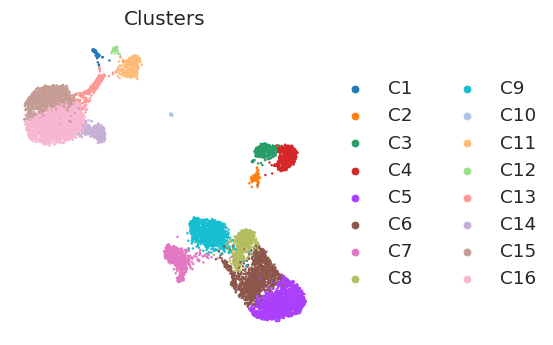

In [43]:
sc.pl.embedding(ad, basis='umap_archr', color='Clusters', frameon=False)

# Imputation examples

## Gene scores

In [62]:
gs_ad = sc.AnnData(ad.obsm['GeneScores'])
gs_ad.obs_names, gs_ad.var_names = ad.obs_names, ad.uns['GeneScoresColums']
gs_ad.obsm['X_umap'] = ad.obsm['X_umap_archr']

<ipython-input-62-2db3df222ee8>:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  gs_ad = sc.AnnData(ad.obsm['GeneScores'].tocsr())


In [63]:
genes = pd.Series([
    "CD34",  #Early Progenitor
    "GATA1", #Erythroid
    "PAX5", "MS4A1", "MME", #B-Cell Trajectory
    "CD14",  #Monocytes
    "CD3D", "CD8A", 'CD4', #TCells,
    'FCGR3A', #'CD16', 
     'LEF1', 'NKG7', 'TREM1', 'LYZ', 'CD19',  'IRF8', 'IRF4',
    'ITGA2B', # CD41,
    'NCAM1', # CD56,
    'CCR7' # Memory T cell
])
genes = genes[genes.isin(ad.uns['GeneScoresColums'])]

In [64]:
# Create a dense matrix with interesting genes
data = pd.DataFrame(gs_ad[:, genes].X.todense(), index=gs_ad.obs_names, columns=genes)
# Impute
imputed_data = impute_data_with_weights(ad, data)

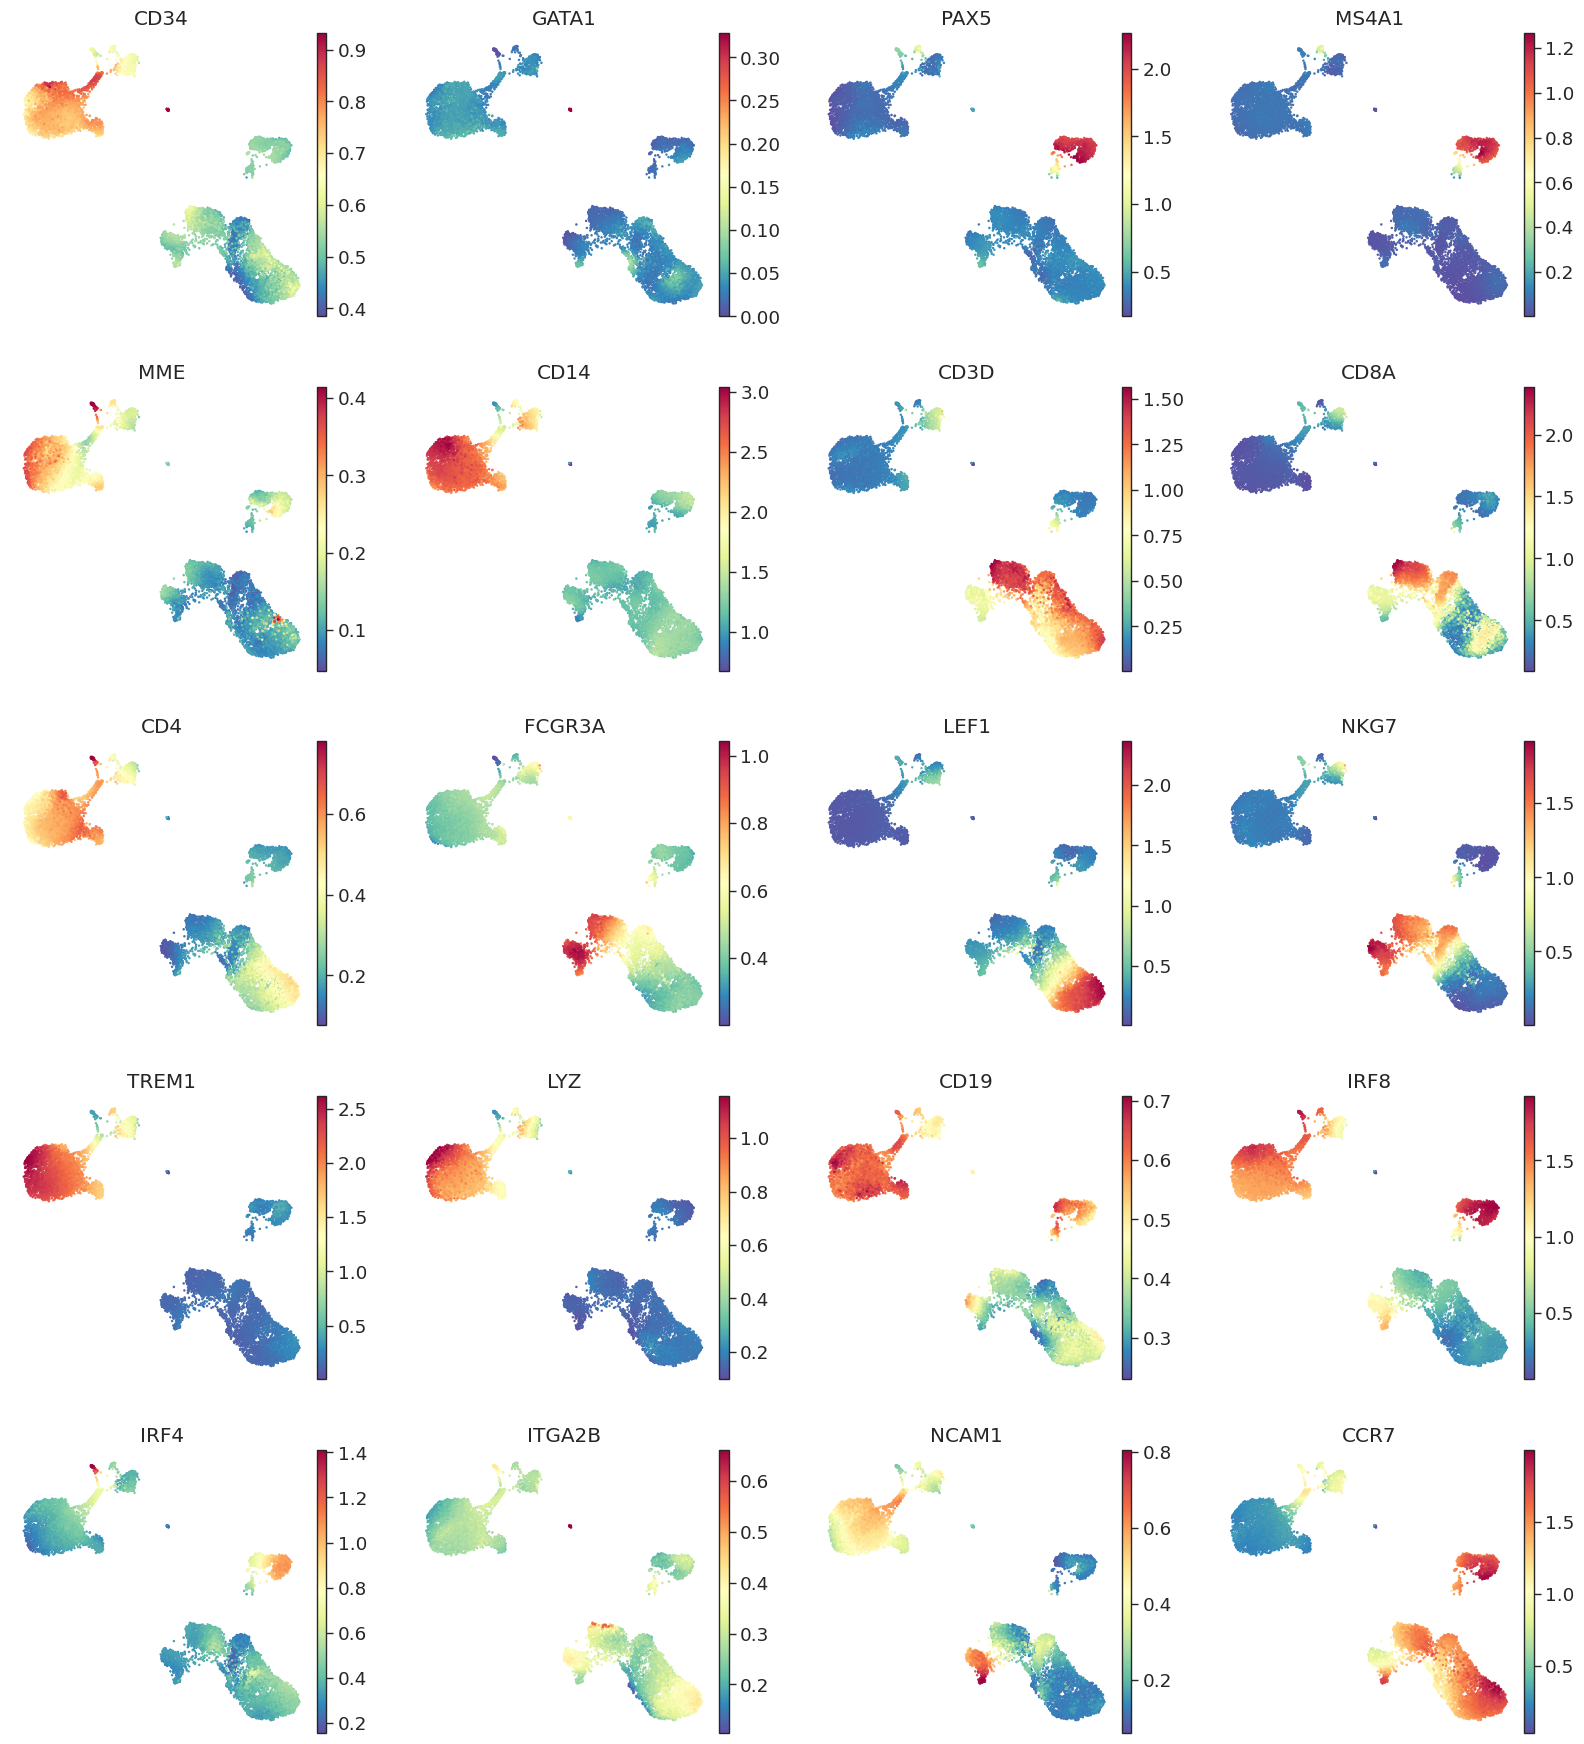

In [67]:
# Plot
temp = gs_ad[:, genes]
temp.layers['Imputed'] = imputed_data

sc.pl.embedding(temp, basis='umap', color=genes, layer='Imputed', frameon=False)

## ChromVAR

In [73]:
chromvar_ad = sc.AnnData(ad.obsm['chromVAR'])
chromvar_ad.obsm['X_umap'] = ad.obsm['X_umap_archr']

<ipython-input-73-c5f868350723>:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  chromvar_ad = sc.AnnData(ad.obsm['chromVAR'])


In [76]:
# We will use all motifs since total < 1000
# Impute
data = pd.DataFrame(chromvar_ad.X, index=chromvar_ad.obs_names, columns=chromvar_ad.var_names)
chromvar_ad.layers['Imputed'] = impute_data_with_weights(ad, data)

In [78]:
chromvar_ad.var_names[chromvar_ad.var_names.str.contains('GATA|PAX')]

Index(['GATA1_383', 'GATA3_384', 'GATA5_385', 'GATA4_386', 'GATA6_387',
       'GATA2_388', 'PAX6_604', 'PAX7_605', 'PAX2_606', 'PAX4_607', 'PAX3_608',
       'PAX8_707', 'PAX1_708', 'PAX5_709', 'PAX9_710'],
      dtype='object')

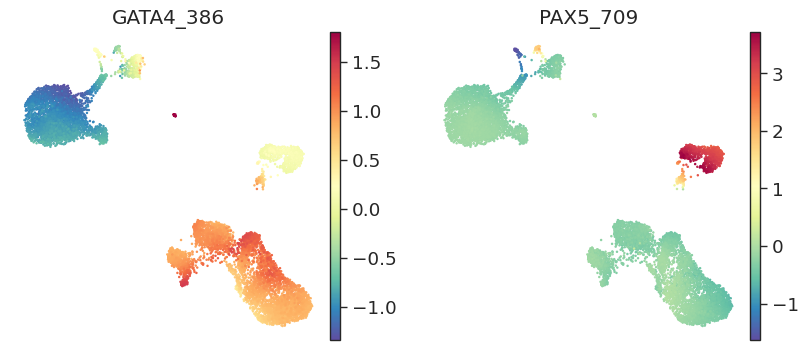

In [79]:
genes = ['GATA4_386', 'PAX5_709']
sc.pl.embedding(chromvar_ad, basis='umap', color=genes, layer='Imputed', frameon=False)

# Save

In [83]:
ad

AnnData object with n_obs × n_vars = 9489 × 155687
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums', 'Clusters_colors', 'DMEigenValues'
    obsm: 'X_svd', 'X_umap_archr', 'GeneScores', 'chromVAR', 'DM_EigenVectors'
    obsp: 'DM_Kernel', 'ImputeWeights'

In [84]:
ad.write(data_dir + '../../pbmc_10k_atac.h5ad')

# Coverage plots

<b> Warning: The following sections are preliminary and should be used with caution </b>

## Functions

In [85]:
import tabix
import subprocess

import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [86]:
def compute_coverage(fragments_file, region, barcodes, out_prefix, 
                     smooth=None, normalize=False, frag_type='All'):

    # Read file
    tb = tabix.open(fragments_file)
    # Query region
    records = tb.querys(region)

    # Bed file
    bed_file = open(out_prefix + '.bed', 'w')

    # Iterate and write bed file
    for record in records:
        if record[3] in barcodes:
            # Write to bed file if the read is NFR
            if frag_type == 'NFR' and int(record[2]) - int(record[1]) > 145:
                continue 
            if frag_type == 'NUC' and int(record[2]) - int(record[1]) <= 145:
                continue 
            
            # Write to bed file
            line = record[0] + '\t' + record[1] + '\t' + record[2] + '\n'
            bed_file.writelines(line)

    # Close bed file
    bed_file.close()

    # Region to bed
    line = region.replace(':', '\t').replace('-', '\t') + '\n'
    bed_file = open(out_prefix + '.region.bed', 'w')
    bed_file.writelines(line)
    bed_file.close()

    # Coverage
    out_file = open(out_prefix + '.coverage.bed', 'w')
    args = ['bedtools', 'coverage', '-a', out_prefix + '.region.bed', '-b',
            out_prefix + '.bed', '-d']
    subprocess.call(args, stdout=out_file)
    out_file.close()

    # Read coverage
    df = pd.read_csv(out_prefix + '.coverage.bed', sep='\t', header=None)
    coverage = pd.Series(df[4].values, index=df[1] + df[3] - 1)
    coverage.attrs['chr'] = df[0][0]

    # Smooth if specified
    if smooth:
        coverage = coverage.rolling(smooth).mean()
        coverage[coverage.isnull()] = coverage.iloc[smooth]

    if normalize:
        norm = 100 / len(barcodes)
        coverage = coverage * norm

    # Clean up
    os.unlink(out_prefix + '.bed')
    os.unlink(out_prefix + '.coverage.bed')
    os.unlink(out_prefix + '.region.bed')

    return coverage

In [87]:
# Plot coverage
def _plot_coverage(coverage, track_name='Coverage', ax=None, color='#ff7f00',
                   min_coverage=0, ylim=None, fill=True):
    if ax is None:
        plt.figure()
        ax = plt.gca()

    # Plot and fill
    values = coverage
    values[values <= min_coverage] = 0
    if fill:
        ax.plot(coverage.index, values, color='black', linewidth=0.05)
        ax.fill_between(coverage.index, 0, values, color=color)
        ax.set_ylabel(track_name)
    else:
        ax.plot(coverage.index, values, color=color)

    # Scale
    if ylim is not None:
        ax.set_ylim(ylim)
    sns.despine(ax=ax)

    
# BED plot
def _plot_bed(plot_peaks, track_name="Bed", ax=None, facecolor='#ff7f00'):

    if ax is None:
        plt.figure()
        ax = plt.gca()
    
    rects = []
    if len(plot_peaks) > 0:
        for s, e in zip(plot_peaks.Start, plot_peaks.End):
            rects.append(Rectangle((s, -0.3), e - s, 0.6))

    # Add rectangles
    # Dummy scatter
    pc = PatchCollection(rects, facecolor=facecolor, edgecolor='black')
    ax.add_collection(pc)

    # Axis annotation
    ax.set_ylim([-1, 1])
    sns.despine(ax=ax, bottom=True)
    ax.set_yticks([])
    ax.set_ylabel(track_name)
    ax.axes.get_xaxis().set_visible(False)


# Gene plot
def _plot_gene(genes, ax=None, track_name='Genes', facecolor='#377eb8',
               exon_height=0.6, utr_height=0.25):
    # Setup plot
    if ax is None:
        plt.figure()
        ax = plt.gca()

    for gene in np.unique(genes.gene_name):
        gene_pr = genes[genes.gene_name == gene]

        # Plot lines
        gs, ge = gene_pr[gene_pr.Feature == 'gene'].Start.values[0], gene_pr[gene_pr.Feature == 'gene'].End.values[0]
        ax.plot([gs, ge], [0, 0], color='black')
        ax.set_ylim([-1, 1])
        ax.text((gs + ge) / 2,
                -(exon_height + utr_height), gene, horizontalalignment='center')

        # UTRs
        utrs = gene_pr[gene_pr.Feature.astype(str).str.contains('utr')]
        if len(utrs) > 0:
            rects = []
            for s, e in zip(utrs.Start, utrs.End):
                rects.append(Rectangle((s, -utr_height / 2), e - s, utr_height))
            ax.add_collection(PatchCollection(rects, facecolor=facecolor, edgecolor='black'))

        # CDS
        cds = gene_pr[gene_pr.Feature.astype(str).str.contains('CDS')]
        if len(cds) == 0:
            cds = gene_pr[gene_pr.Feature.astype(str).str.contains('exon')]
        rects = []
        for s, e in zip(cds.Start, cds.End):
            rects.append(Rectangle((s, -exon_height / 2), e - s, exon_height))
        ax.add_collection(PatchCollection(rects, facecolor=facecolor, edgecolor='black'))

        # Arrow indicating direction
        rs, re = ax.get_xlim()
        if gene_pr.stranded:
            s, e = cds.Start.values[0], cds.End.values[0]
            if gene_pr.Strand.values[0] == '+':
                ax.plot([s, e], np.repeat(-0.65, 2), color='red', linewidth=1, alpha=1)
                ax.plot([e - (re - rs) / 100, e], [-0.95, -0.65], color='red', linewidth=1, alpha=1)
                ax.plot([e - (re - rs) / 100, e], [-0.35, -0.65], color='red', linewidth=1, alpha=1)
            else:
                ax.plot([s, e], np.repeat(-0.65, 2), color='red', linewidth=1, alpha=1)
                ax.plot([s + (re - rs) / 100, s], [-0.95, -0.65], color='red', linewidth=1, alpha=1)
                ax.plot([s + (re - rs) / 100, s], [-0.35, -0.65], color='red', linewidth=1, alpha=1)

    # Axis clean up
    ax.set_ylabel(track_name)
    sns.despine(ax=ax)
    ax.set_yticks([])

In [88]:
def plot_coverage(barcode_groups, region, fragments_file,
                  peak_groups=None, genes=None, highlight_peaks=None,
                  min_coverage=0, smooth=None, common_scale=False,
                  plot_cov_size=2, plot_bed_size=0.75, collapsed=False,
                  coverage_colors=None, fig_width=15, frag_type='All', normalize=True):

    # Determine coverages
    coverages = dict()
    for k in barcode_groups.index:
        iter_norm = normalize
        if k == 'Single-cell':
            iter_norm = False
        coverages[k] = compute_coverage(fragments_file, region, barcode_groups[k],
                                        '/tmp/test', smooth, iter_norm, frag_type)
    # Plot
    n_rows = len(coverages)
    size = plot_cov_size * n_rows
    ratios = np.repeat(1, n_rows)
    if collapsed:
        n_rows = 1
        size = plot_cov_size * 4
        ratios = np.repeat(4, 1)
    if peak_groups is not None:
        size += plot_bed_size * len(peak_groups)
        n_rows += len(peak_groups)
        ratios = np.append(ratios, np.repeat(plot_bed_size / plot_cov_size, len(peak_groups)))
    if genes is not None:
        size += plot_bed_size
        n_rows += 1
        ratios = np.append(ratios, plot_bed_size / plot_cov_size)

    # Colors
    if coverage_colors is None:
        coverage_colors = pd.Series(sns.color_palette('Set2', len(coverages)).as_hex(),
                                    index=barcode_groups.index)

    # Y min and max
    ylim = None
    if common_scale:
        ymin = np.inf
        ymax = -np.inf
        for row in barcode_groups.index:
            if row == 'Single-cell':
                continue
            ymin = np.min([ymin, np.min(coverages[row])])
            ymax = np.max([ymax, np.max(coverages[row])])
        ylim = [ymin, ymax]


    # Region pyranges
    pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})
    if highlight_peaks is not None:
        highlight_peaks = highlight_peaks.overlap(pr_region)
        
    # Plot
    fig = plt.figure(figsize=[fig_width, size])
    gs = gridspec.GridSpec(n_rows, 1, height_ratios=ratios, figure=fig)

    # Coverages
    plot_index = 0
    if collapsed:
        ax = fig.add_subplot(gs[plot_index, 0])
        ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
        plot_index += 1

    for row in barcode_groups.index:
        # Create subplot
        if not collapsed:
            ax = fig.add_subplot(gs[plot_index, 0])
            ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
            plot_index += 1

        iter_ylim = ylim
        if row == 'Single-cell':
            iter_ylim = [0, 2]
        _plot_coverage(coverages[row], row, ax, coverage_colors[row],
                       min_coverage, iter_ylim, not collapsed)

        # Highlight peaks
        if highlight_peaks is not None:
            for s, e in zip(highlight_peaks.Start, highlight_peaks.End):
                rect = Rectangle((s, 0), e - s, ax.get_ylim()[1],
                                 color='black', alpha=0.07, zorder=1000)
                ax.add_patch(rect)

        # Reset axis
        if plot_index != n_rows:
            ax.set_xticks([])


    # Region pyranges
    pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})

    # Peaks
    if peak_groups is not None:
        for row in peak_groups.index:
            plot_peaks = peak_groups[row].overlap(pr_region)

            ax = fig.add_subplot(gs[plot_index, 0])
            ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
            plot_index += 1

            _plot_bed(plot_peaks, row, ax)

    # Genes
    if genes is not None:
        genes = genes.overlap(pr_region)
        genes.End[genes.End > pr_region.End[0]] = pr_region.End[0]
        genes.Start[genes.Start < pr_region.Start[0]] = pr_region.Start[0]


        # Setup plot
        ax = fig.add_subplot(gs[plot_index, 0])
        ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
        plot_index += 1

        _plot_gene(genes, ax, track_name='Genes')

        # Axis clean up
        ax.set_ylabel('Genes')
        sns.despine(ax=ax)
        ax.set_yticks([])


    # Clean up axis annotation
    ax.axes.get_xaxis().set_visible(True)
    locs = ax.get_xticks()[[0, -1]]
    locs[0] += 10000
    locs[1] -= 10000
    ax.set_xticks(locs)
    ax.set_xticklabels([str(int(t)) for t in ax.get_xticks()])
    ax.set_xlabel(region.split(':')[0])





## GTF

In [ ]:
# Download hg19 gtf file from ENSEMBL (https://www.ensembl.org) and replace with the path
gtf = pr.read_gtf('/fh/fast/setty_m/grp/gtfs/hg19.gtf')

## Fragments file

In [42]:
# Download the fragments file and replace the path
fragments_file = '/fh/fast/setty_m/grp/public-datasets/10x_pbmc_10k_scatac/atac_pbmc_10k_nextgem_fragments.tsv.gz'

In [43]:
# Cell names should be consistent with fragments file
ad.obs['FragSample'] = ad.obs_names.str.split('#').str.get(1)

## Barcode groups

In [49]:
# A track for each cluster
barcode_groups = pd.Series(dtype=object)
for cat in ['0', '1', '2', '4', '7', '10', '14', '17']:
    barcode_groups[f'Clstr {cat}'] = ad.obs['FragSample'][ad.obs['phenograph'] == cat].values

## Peaks

In [51]:
peak_groups = pd.Series()
peak_groups['Peaks'] = pyranges_from_strings(ad.var_names)

<ipython-input-51-48a45130fc55>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  peak_groups = pd.Series()


## Plot

In [55]:
# Pax5 locus 
region = 'chr21:36,160,098-36,421,595'.replace(',', '')
pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})

genes = gtf.intersect(pr_region)

In [56]:
cluster_colors = pd.Series(ad.uns['phenograph_colors'], index=ad.obs['phenograph'].values.categories)
cluster_colors.index = 'Clstr ' + cluster_colors.index
cluster_colors = cluster_colors[barcode_groups.index]

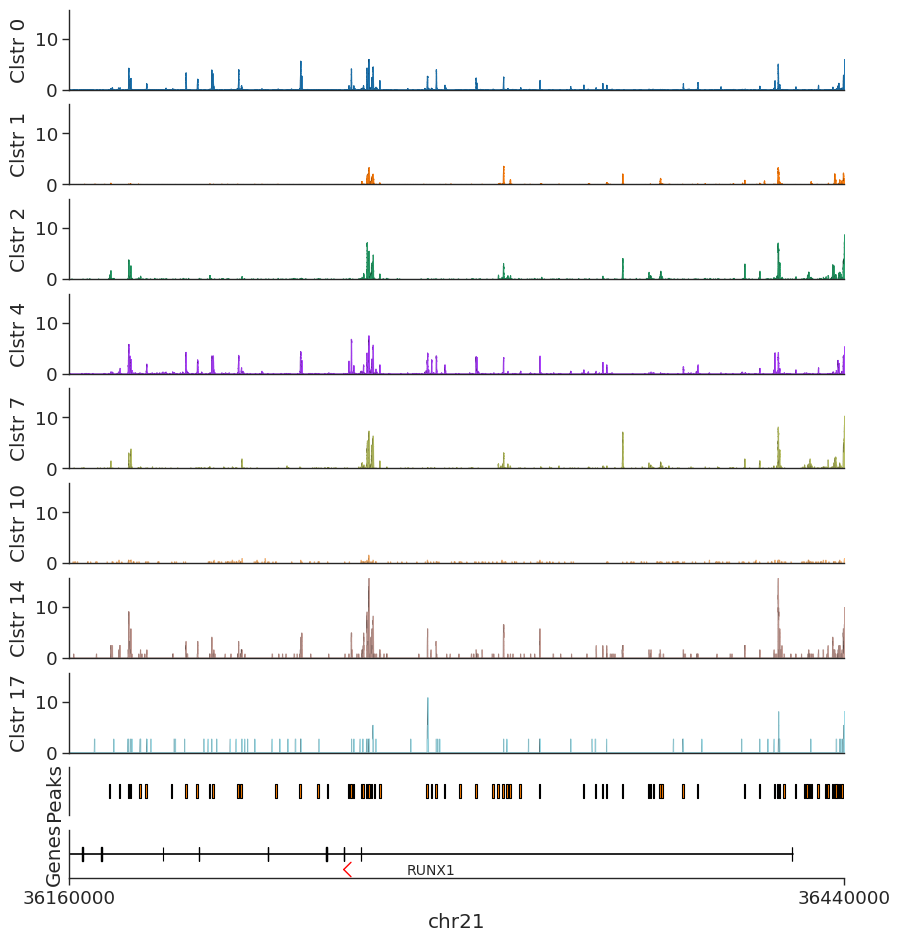

In [57]:
plot_coverage(barcode_groups, region, fragments_file, 
              peak_groups, genes=genes, highlight_peaks=None,
              common_scale=True, smooth=1, coverage_colors=cluster_colors, 
             fig_width=10,  plot_cov_size = 1.25, frag_type='NFR', normalize=True)



# Motifs 

## Peak sequences

In [60]:
peaks_pr = pyranges_from_strings(ad.var_names)

### Export

In [61]:
motifs_dir = 'data/pbmc_10x_atac/motifs/'
os.makedirs(motifs_dir, exist_ok=True)

In [62]:
peaks_df = pd.DataFrame()
# Positionns
peaks_df['chrom'] = peaks_pr.Chromosome
peaks_df['chromStart'] = peaks_pr.Start
peaks_df['chromEnd'] = peaks_pr.End

# summit
peaks_df['summit']  = 250

# Score
peaks_df['score'] = 1

# Names
peaks_df['name'] = peaks_df['chrom'].astype(str) + ':' + peaks_df['chromStart'].astype(str) + '-' + peaks_df['chromEnd'].astype(str)

peaks_df.to_csv(motifs_dir + 'peaks.bed', sep='\t', index=None, header=True)

### Sequences

Run this in R

```
# Install and install SeqGL from here: https://github.com/ManuSetty/SeqGL
library(SeqGL)

span <- 150
org <- 'hg19'

# Peaks directory
motifs.dir <- 'data/pbmc_10x_atac/motifs/'
peaks.file <- sprintf("%s/peaks.bed", motifs.dir)

# Load peaks 
regions <- read.table (peaks.file, stringsAsFactors=FALSE, header=TRUE)
all.regions <- GRanges (regions[,'chrom'], IRanges (regions[,'chromStart'], regions[,'chromEnd']),
    score=regions[,'score'], summit=regions[,'summit'], name=regions[,'name'])
start (all.regions) <- end (all.regions) <- start (all.regions) + all.regions$summit - 1
all.regions <- resize (all.regions, fix='center', span)


# Identify sequences and flag any sequences with N
seqs <- SeqGL:::get.seqs (SeqGL:::load.bsgenome (org), all.regions)
names(seqs) <- all.regions$name
# Save 
writeXStringSet(seqs, sprintf("%s/all_seqs.fa", motifs.dir))
```

### FIMO

Install FIMO from here: https://meme-suite.org/meme/doc/fimo.html

```
fimo  -oc fimo  /fh/fast/setty_m/grp/motif_databases/CIS-BP_2.00/Homo_sapiens.meme all_seqs.fa 
```

### Matrix

In [64]:
import tqdm

fimo_res = 'data/10x_pbmc_10k_scatac/fimo/fimo.tsv'

In [ ]:
# Create matrix
# Motif information 
motifs = pd.Series()
motif_index = 0

# Peak index
peak_index = pd.Series(range(len(ad.var_names)), index=ad.var_names)

# Values
num_records = int(subprocess.run(['wc', '-l', fimo_res], stdout=subprocess.PIPE).stdout.decode().split(' ')[0]) - 5
x = np.zeros(num_records)
y = np.zeros(num_records)
values = np.zeros(num_records)

# Read file
rec_index = 0
for line in tqdm.tqdm(open(fimo_res, 'r')):
    # Skip first line 
    split = line.split('\t')
    if split[0] == 'motif_id':
        continue
    
    if len(split) == 1:
        break
        
    # Update motifs if necessary
    if split[1] not in motifs:
        motifs[split[1]] = motif_index
        motif_index += 1

    # Update record
    x[rec_index] = peak_index[split[2]]
    y[rec_index] = motifs[split[1]]
    values[rec_index] = float(split[6])
    rec_index += 1

In [ ]:
# Sparse matrix
from scipy.sparse import csr_matrix
pwm_scores = csr_matrix((values, (x, y)), (ad.shape[1], motif_index))
pwm_ad = sc.AnnData(pwm_scores)
pwm_ad.obs_names = ad.var_names
pwm_ad.var_names = motifs.index
pwm_ad.write(motifs_dir + 'fimo_pwm_scores.h5ad')

pwm_ad